In [28]:
import pydub
import numpy as np
import sounddevice as sd
import cmath
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from math import e

class Music: # static class for music I/O standard
    
    @staticmethod
    def plotter(x=None, y=None, title="", xlabel="", ylabel="", figsize=(20, 12), subplt=(1, 1, 1)):
        """
            East plotter
        """
        if x is None:
            x = np.arange(y.shape[0])
        plt.figure(figsize=figsize)
        plt.subplot(subplt)
        plt.plot(x, y)
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        return
    
    @staticmethod
    def frequencies(x, fs):
        """
            Audio vector to frequencies with FFT ratio
        """
        Fd = np.fft.fft(x)
        Fx = np.linspace(0, 1, max(x.shape))*fs
        return Fd, Fx
    
    @staticmethod
    def read_mp3(filename, normalized=False):
        """
            MP3 to numpy array
        """
        a = pydub.AudioSegment.from_mp3(filename)
        y = np.array(a.get_array_of_samples())
        if a.channels == 2:
            y = y.reshape((-1, 2))
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    
    @staticmethod
    def write_mp3(filename, Fs, x, normalized=False):
        """ 
            numpy array to MP3 
        """
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
        song.export(filename, format="mp3", bitrate="320k")
        return

# plotter function
def freqplot(y, fs, N, t1="The signal", t2="Frequency"):

    x = np.linspace(0, y.shape[0]/fs, y.shape[0]) # Zero to 2*pi, one period
    f = np.fft.fft(y)
    p = np.linspace(0, fs, y.shape[0])

    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(t1)
    
    plt.subplot(2, 1, 2)
    plt.plot(p[:N], np.abs(f[:N]))
    plt.grid(True)
    plt.xlabel("Frequency")
    plt.title(t2)
    plt.show()


# Echo

I first extended the input data to n*t*fs + data.shape[0] data. Then in a for, i first shifted the extended input i * fs * t to right.

Then i damped this shifted signal by multiplying it with damp^i and finally i just added the signals together and thats it.

In [103]:
def echosound(filename, output_filename, n, t, damp = 0.5):
    ## Reading audio
    fs, data = Music.read_mp3(filename)
    #sd.play(data, fs)
    data_per_echo = int(fs * t)
    
    output = np.zeros(data.shape[0] + n * data_per_echo)
    data_extended = np.zeros(data.shape[0] + n * data_per_echo)
    data_extended[0:data.shape[0]] = data
    
    for i in range(n):
        nth_echo = np.roll(data_extended, i * data_per_echo)
        nth_echo_damped = nth_echo * (damp**i)
        output = output + nth_echo_damped
    output = output / (n * 40000)
    #sd.play(output, fs)
    
    #Original Data Plot
    freqplot(data, fs, data.shape[0])
    
    #Echo Data
    freqplot(output, fs, output.shape[0])
    
    Music.write_mp3(output_filename, fs, output, True)
    return fs, output

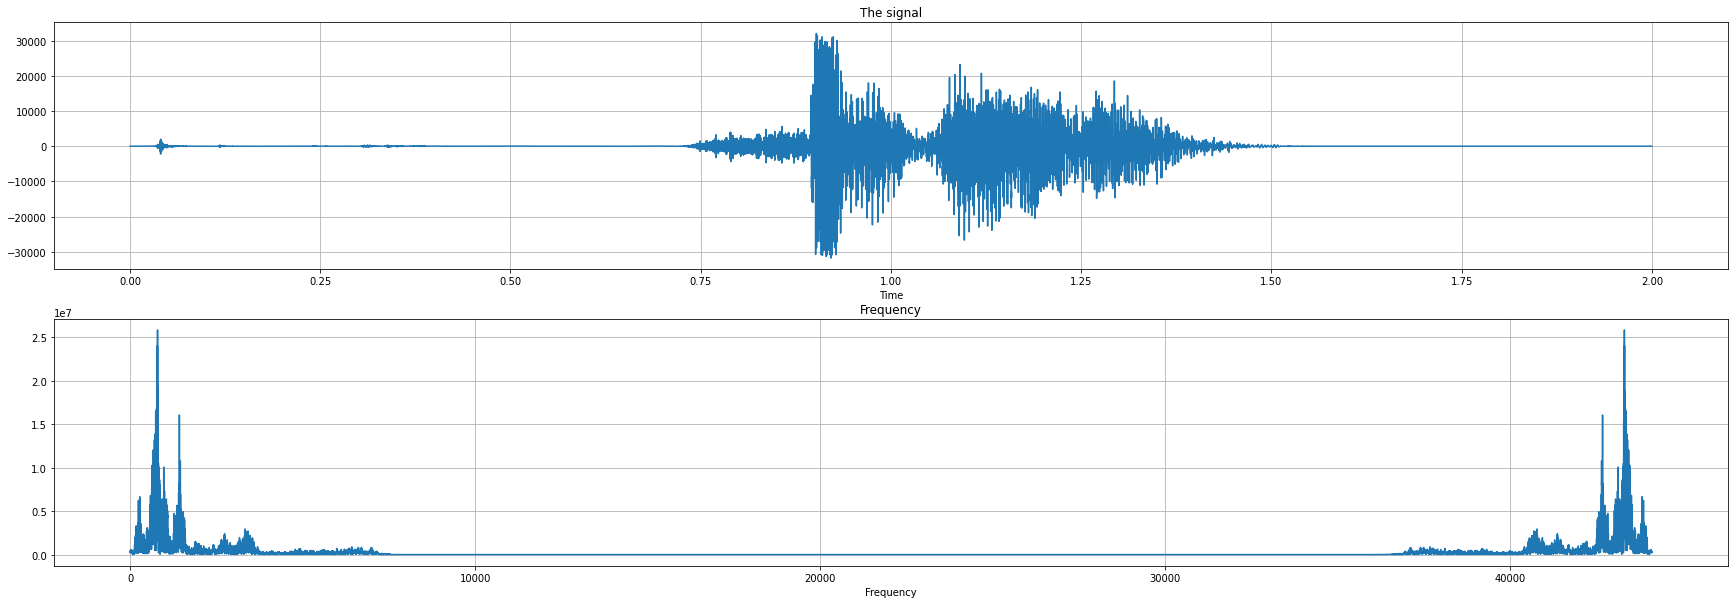

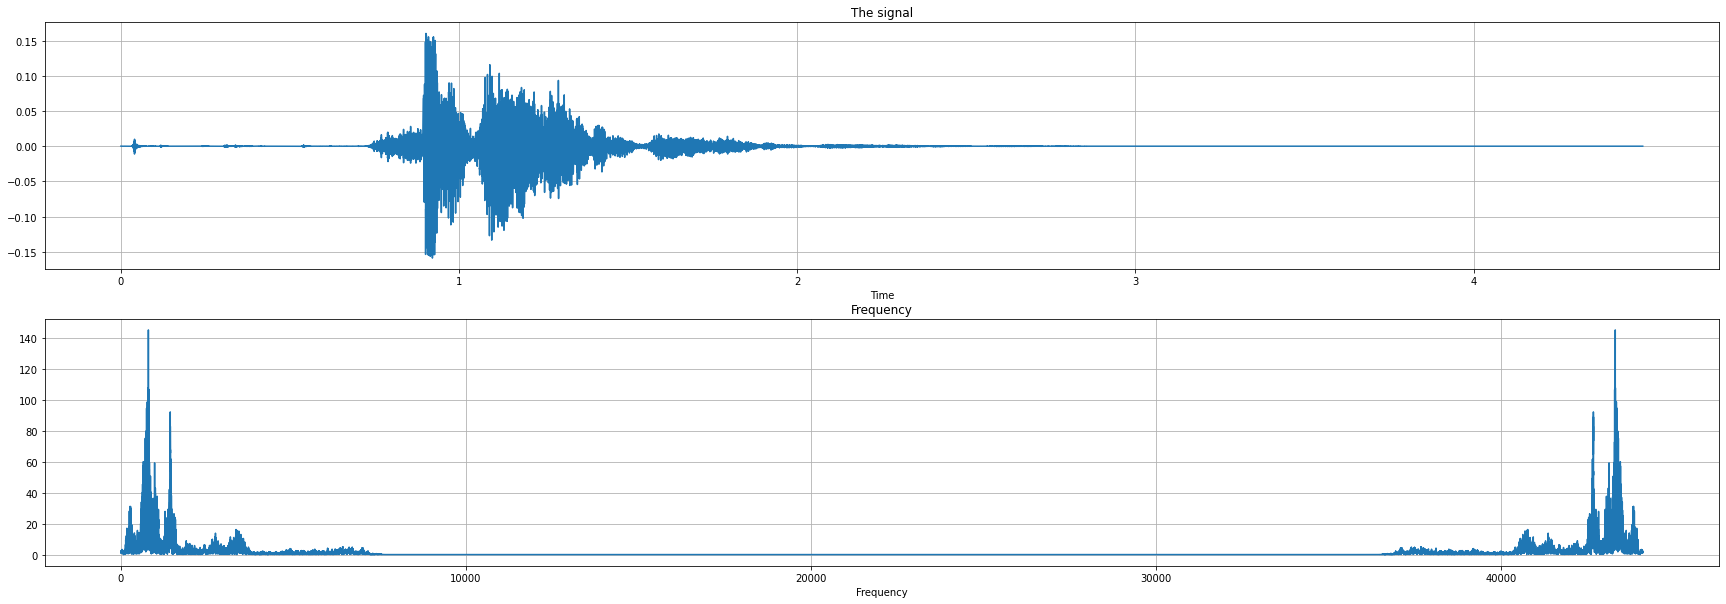

In [104]:
fs, output = echosound('musics/echo_before.mp3', 'musics/echo_after.mp3', 5, 0.5, 0.15)